# Imports

In [318]:
# Third Party
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

# Native
import os

# Load Data

In [2]:
# PostgreSQL credentials and database details
load_dotenv() # take environment variables from .env.
db_user = os.getenv("POSTGRESQL_USERNAME")
db_password = os.getenv("POSTGRESQL_PWD")
db_host = 'localhost' # Or your PostgreSQL server IP/hostname
db_port = '5432'      # Default PostgreSQL port
db_name = 'tile_db'

In [8]:
cluster_label = 'cluster_label' # norm_cluster_label , cluster_label
table_name = 'miles_walked_by_cluster' if cluster_label == 'cluster_label' else 'miles_walked_by_norm_cluster'
tagquery = f"""
SELECT 
	t.{cluster_label},
	t.tag,
	mn.miles_walked_in_cluster

FROM tags as t
INNER JOIN {table_name} as mn
ON t.{cluster_label} = mn.{cluster_label}
;
"""
weatherquery = f"""
WITH weather_data as (SELECT 
	tdj.{cluster_label},
	AVG(w.temperature_2m) as temperature_C,
	AVG(w.relative_humidity_2m) as rel_humidity,
	AVG(w.cloud_cover) AS cloud_cover,
	AVG(w.is_day) AS is_day,
	AVG(w.precipitation) AS precipitation
FROM weather as w
INNER JOIN tile_data_john as tdj
ON w.index = tdj.index
GROUP BY tdj.{cluster_label})

SELECT
	m.miles_walked_in_cluster,
	w.*
FROM {table_name} as m
INNER JOIN weather_data as w
ON m.{cluster_label} = w.{cluster_label}
;
"""
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
tagdf = pd.read_sql(tagquery, engine)
weatherdf = pd.read_sql(weatherquery, engine)
engine.dispose()
df = pd.merge(weatherdf, tagdf[[cluster_label,'tag']], how='left', on=cluster_label)
df

,miles_walked_in_cluster,cluster_label,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,tag
0,233.318354,-1,18.504318,76.747098,63.000893,0.509878,0.194324,outlier
1,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,establishment
2,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,museum
3,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,point_of_interest
4,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,street_address
...,...,...,...,...,...,...,...,...
8811,0.000292,1788,23.872692,81.917865,66.538462,1.000000,0.007692,subpremise
8812,0.000292,1788,23.872692,81.917865,66.538462,1.000000,0.007692,premise
8813,0.000292,1788,23.872692,81.917865,66.538462,1.000000,0.007692,street_address
8814,0.000292,1788,23.872692,81.917865,66.538462,1.000000,0.007692,plus_code


# Weather Data Exploration

In [4]:
lowq = df['miles_walked_in_cluster'].quantile(.25)
highq = df['miles_walked_in_cluster'].quantile(.9)
print(f"Including data between {lowq:.2f} and {highq:.2f} miles walked")
cdf = df[(df[cluster_label]>=0) & (df['miles_walked_in_cluster'].between(lowq,highq))].copy()
X = cdf[['temperature_c','rel_humidity','cloud_cover','is_day','precipitation']]
y = cdf['miles_walked_in_cluster']
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.corrwith(y)

Including data between 0.06 and 1.11 miles walked


0    0.028882
1   -0.023932
2    0.089733
3    0.120987
4    0.015642
dtype: float64

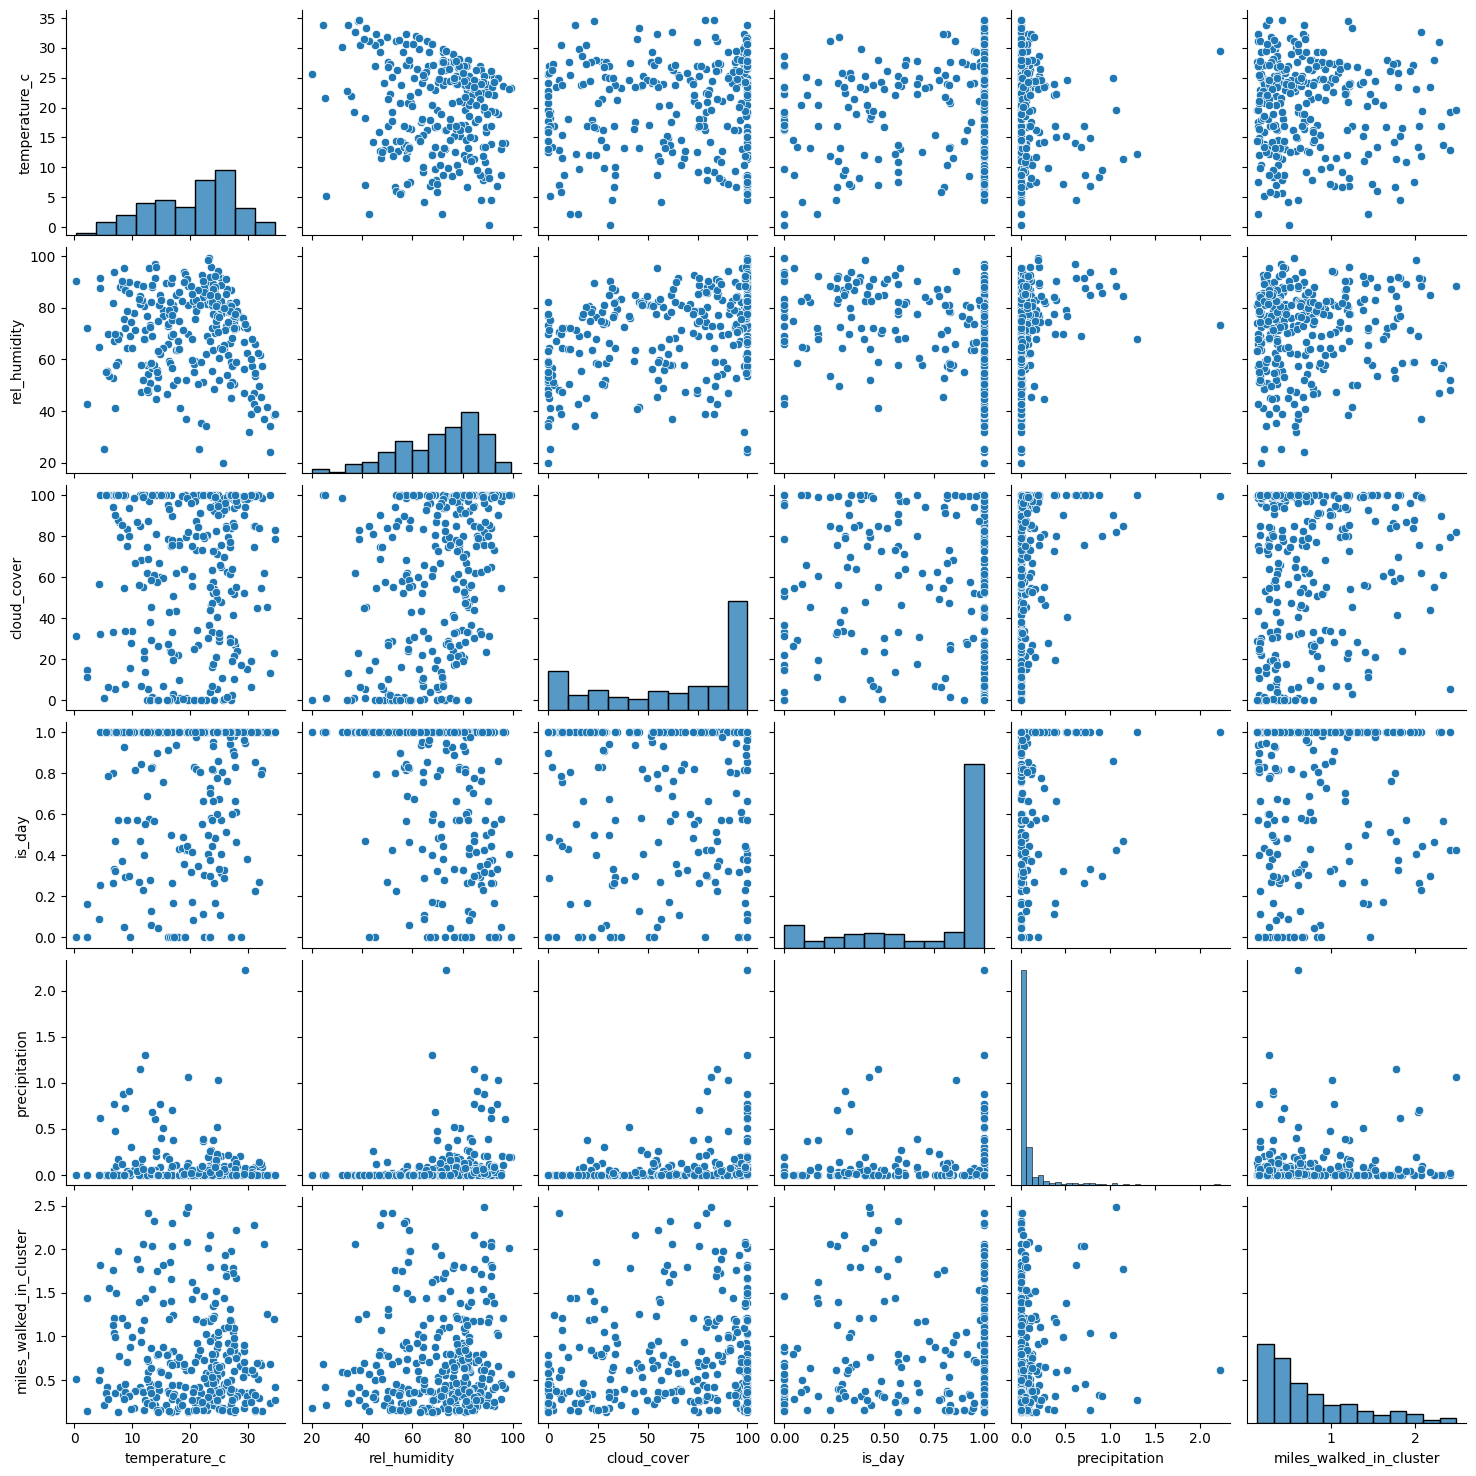

In [206]:
sns.pairplot(cdf[['temperature_c','rel_humidity','cloud_cover','is_day','precipitation','miles_walked_in_cluster']])

# Tags Data Exploration

<BarContainer object of 28 artists>

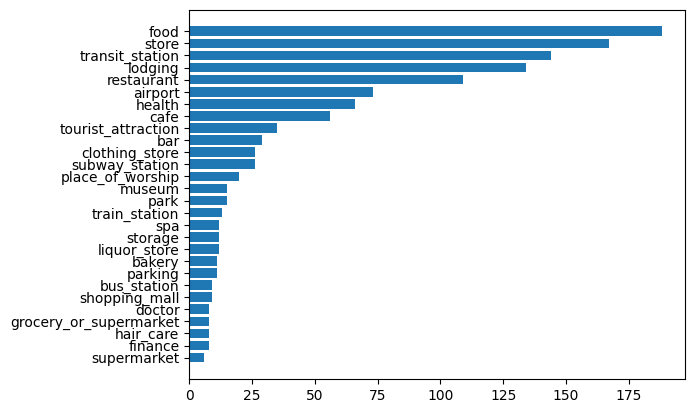

In [9]:
tag_counts = tagdf['tag'].value_counts().sort_values(ascending=True).reset_index()
not_interesting_tags = list(tag_counts['tag'].tail(7).values) + ['political'] + [tag for tag in tag_counts['tag'].unique() if 'locality' in tag]
tag_counts = tag_counts[(tag_counts['count'] > 5) & (~tag_counts['tag'].isin(not_interesting_tags))]
fig, ax = plt.subplots()
ax.barh(y=tag_counts['tag'], width=tag_counts['count'].values)

# Data Prep

In [10]:
# remove boring tags and any that show up less than 5 times from above
mldf = df[tagdf['tag'].isin(tag_counts['tag'])]
# from initial exploration, models perform awful on clusters with miles walked > 10 -- must be something weird happening
# realistically we only had ~3-4 days when we walked more than 10 miles
lowq = df['miles_walked_in_cluster'].quantile(.1)
highq = df['miles_walked_in_cluster'].quantile(.9)
print(f"Including data between {lowq:.2f} and {highq:.2f} miles walked")
mldf = mldf[df['miles_walked_in_cluster'].between(lowq,highq)].copy()
tags = list(tag_counts['tag'].values)
mldf.loc[:, tags] = pd.get_dummies(mldf['tag'], dtype=float)
mldf = mldf[[cluster_label, 'miles_walked_in_cluster','temperature_c','rel_humidity','cloud_cover','is_day','precipitation'] + tags]
mldf = mldf.groupby(cluster_label).max().reset_index().dropna(axis=1, how='all')
mldf

Including data between 0.01 and 1.11 miles walked


C:\Users\joyam\AppData\Local\Temp\ipykernel_19676\1167977408.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mldf = mldf[df['miles_walked_in_cluster'].between(lowq,highq)].copy()


,cluster_label,miles_walked_in_cluster,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,supermarket,hair_care,grocery_or_supermarket,shopping_mall,bus_station,parking,bakery,liquor_store,storage,spa,park,museum,place_of_worship,subway_station,clothing_store,bar,tourist_attraction,cafe,health,airport,restaurant,lodging,transit_station,store,food
0,2,0.176681,17.927586,66.904978,96.155172,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.369790,16.066854,64.661242,98.958333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,0.263219,13.121500,73.190652,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,1.027868,22.755500,62.027584,100.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,66,0.145550,17.581844,63.557781,43.312500,0.937500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,3009,0.139262,24.453286,93.175870,99.642857,0.071429,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,3014,0.082475,23.927638,92.582653,97.957447,0.063830,0.040426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,3017,0.141374,24.220455,91.628159,99.909091,0.181818,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
558,3020,0.028751,24.120667,94.164371,97.444444,0.000000,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X = mldf.drop(columns=[cluster_label,'miles_walked_in_cluster'])
y = mldf['miles_walked_in_cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"training: {X_train.shape[0]}\ntesting: {X_test.shape[0]}")

training: 448
testing: 112


In [12]:
X.corrwith(y).sort_values(ascending=False)

is_day                    0.121196
food                      0.081961
shopping_mall             0.036392
transit_station           0.033119
restaurant                0.018410
bus_station               0.013336
museum                    0.010966
cloud_cover               0.009046
lodging                   0.007039
tourist_attraction        0.006135
supermarket               0.006067
parking                   0.005688
cafe                      0.005141
park                      0.004119
clothing_store           -0.006173
bar                      -0.013160
rel_humidity             -0.014937
temperature_c            -0.018290
store                    -0.024448
storage                  -0.030078
bakery                   -0.030918
place_of_worship         -0.031417
spa                      -0.033784
liquor_store             -0.038560
airport                  -0.042666
hair_care                -0.045482
grocery_or_supermarket   -0.045563
precipitation            -0.054689
health              

# Modelling

## Simple

In [272]:
def plot_results(y_pred, y_test, ax1, ax2, title):
    z = np.polyfit(y_pred, y_test, 1)
    p = np.poly1d(z)
    ax1.scatter(y_pred,y_test);
    ax1.plot(y_pred, p(y_pred), "r-", linewidth=.5)
    ax1.set_xlabel('Predicted');
    ax1.set_ylabel('True');
    ax1.set_title(title)
    ax2.hist(y_pred-y_test, bins=20);
    ax2.set_xlabel('Residual');
    ax2.set_ylabel('Count');

In [273]:
lr = LinearRegression()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

lr = Lasso()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

lr = Ridge()
scores = cross_validate(lr,X,y,cv=10)
print(np.mean(scores['test_score']))

-0.06279111505085073
-0.01911928887155192
-0.04267331704130588


-0.10254061311553175
-0.00013413173950427293
-0.10218121763696586
-0.13633802845274334


C:\Users\joyam\AppData\Local\Temp\ipykernel_7104\464861256.py:2: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y_pred, y_test, 1)


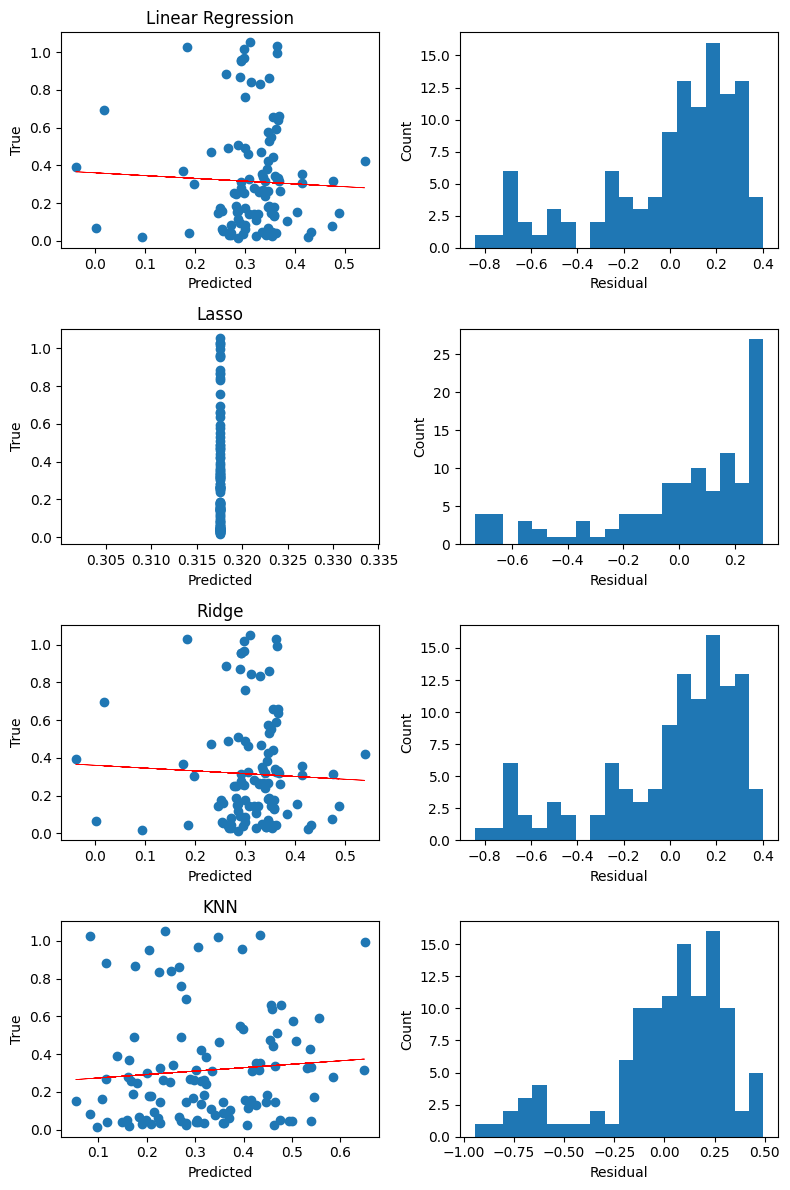

In [274]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(lr.score(X_test, y_test))

la = Lasso()
la.fit(X_train, y_train)
la_pred = la.predict(X_test)
print(la.score(X_test, y_test))

ri = Ridge()
ri.fit(X_train, y_train)
ri_pred = ri.predict(X_test)
print(ri.score(X_test, y_test))

knn = KNeighborsRegressor(n_neighbors = 5, n_jobs=-1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

fig, ax = plt.subplots(4,2, figsize=(8,12), layout='tight')
plot_results(lr_pred, y_test, ax[0,0], ax[0,1], 'Linear Regression')
plot_results(la_pred, y_test, ax[1,0], ax[1,1], 'Lasso')
plot_results(ri_pred, y_test, ax[2,0], ax[2,1], 'Ridge')
plot_results(knn_pred, y_test, ax[3,0], ax[3,1], 'KNN')

## Simple +

In [267]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
lr = LinearRegression()
lr_scores = cross_validate(lr,X_poly,y,cv=10, return_estimator=True)
print(np.mean(scores['test_score']))

lr = Lasso()
scores = cross_validate(lr,X_poly,y,cv=10)
print(np.mean(scores['test_score']))

lr = Ridge()
scores = cross_validate(lr,X_poly,y,cv=10)
print(np.mean(scores['test_score']))

-0.03277936367101532
-0.03534017249443912
-0.23600548632643165


In [268]:
lr_best = lr_scores['estimator'][np.argmax(lr_scores['test_score'])]
f"{poly.get_feature_names_out()[np.argmax(lr_best.coef_)]} : {np.max(lr_best.coef_)}"
feature_names = poly.get_feature_names_out()
feature_values = lr_best.coef_
feats = {name:value for name, value in zip(feature_names, feature_values)}
feats = {k:v for k,v in sorted(feats.items(), key=lambda item: -item[1])}
feats

{'precipitation food': np.float64(3.0937541799935495),
 'airport': np.float64(2.8629673448631294),
 'airport^2': np.float64(2.8629673448595656),
 'is_day cafe': np.float64(1.167425067898048),
 'precipitation health': np.float64(0.9395553803732826),
 'temperature_c bar': np.float64(0.7448208177231793),
 'is_day health': np.float64(0.5330006448351284),
 'transit_station food': np.float64(0.5263905269690466),
 'food': np.float64(0.524605930310255),
 'food^2': np.float64(0.5246059302978204),
 'is_day store': np.float64(0.4306595465832641),
 'precipitation transit_station': np.float64(0.415216239594425),
 'restaurant transit_station': np.float64(0.39456113427679695),
 'is_day airport': np.float64(0.3866151310922741),
 'is_day food': np.float64(0.28292104596475387),
 'rel_humidity bar': np.float64(0.2520997165962203),
 'precipitation cafe': np.float64(0.23701274190790284),
 'precipitation airport': np.float64(0.2278059745281118),
 'restaurant food': np.float64(0.15997795118374988),
 'precipi

## Pytorch

In [299]:
df.head(3)

,miles_walked_in_cluster,cluster_label,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,tag
0,233.318354,-1,18.504318,76.747098,63.000893,0.509878,0.194324,outlier
1,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,establishment
2,167.208036,2095,7.330000,56.494829,69.900000,0.080000,0.000000,museum


In [364]:
# Process Data
cdf = df[(df['cluster_label'] > 0) & (df['miles_walked_in_cluster'] < 10)].copy()
tags = list(cdf['tag'].unique())
cdf.loc[:, tags] = pd.get_dummies(cdf['tag'], dtype=float)

svd = TruncatedSVD(n_components=4)
scaler = StandardScaler()
X = cdf.drop(columns=['miles_walked_in_cluster','tag','cluster_label'])
y = cdf['miles_walked_in_cluster'].astype(float)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=66)
X_train = svd.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)
sample_weights_train = np.ones((X_train.shape[0],1))
X_val = svd.transform(X_val)
X_val = scaler.transform(X_val)
sample_weights_val = np.ones((X_val.shape[0],1))
# Convert NumPy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).to(torch.float32)
y_train = torch.from_numpy(np.array(y_train).reshape(-1,1)).to(torch.float32)
sample_weights_train = torch.from_numpy(sample_weights_train).to(torch.float32)
X_val = torch.from_numpy(X_val).to(torch.float32)
y_val = torch.from_numpy(np.array(y_val).reshape(-1,1)).to(torch.float32)
sample_weights_val = torch.from_numpy(sample_weights_val).to(torch.float32)

# Create Datasets
train_dataset = TensorDataset(X_train, y_train, sample_weights_train)
val_dataset = TensorDataset(X_val, y_val, sample_weights_val)

# Create DataLoaders
BATCH_SIZE = X_train.shape[0]
NUM_WORKERS = os.cpu_count() - 1
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS) # No need to shuffle validation data

print(f"Batch size: {BATCH_SIZE}")
print(f"Number of training batches per epoch: {len(train_loader)}")
print(f"Number of validation batches per epoch: {len(val_loader)}")

Batch size: 6161
Number of training batches per epoch: 1
Number of validation batches per epoch: 1


In [365]:
class DeeperNN(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super(DeeperNN, self).__init__()
        self.input = nn.Linear(input_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features) # Normalizes across the feature dimension (hidden_features)
        self.dropout = nn.Dropout(p=.5) # Dropout after activation
        self.hidden_layer = nn.Linear(hidden_features,hidden_features)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_features, output_features)

    def forward(self, x):
        x = self.input(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.hidden_layer(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.hidden_layer(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.output_layer(x)
        return x
    
model = DeeperNN(input_features=X_train.shape[1], hidden_features=16, output_features=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Early Stopping Parameters
patience = 50 # How many epochs to wait for improvement before stopping
min_delta = 0.0001

best_val_loss = float('inf') # Initialize with a very large number
epochs_no_improve = 0
early_stop = False
summary(model, input_size= (4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]              80
       BatchNorm1d-2                   [-1, 16]              32
              ReLU-3                   [-1, 16]               0
           Dropout-4                   [-1, 16]               0
            Linear-5                   [-1, 16]             272
       BatchNorm1d-6                   [-1, 16]              32
              ReLU-7                   [-1, 16]               0
           Dropout-8                   [-1, 16]               0
            Linear-9                   [-1, 16]             272
      BatchNorm1d-10                   [-1, 16]              32
             ReLU-11                   [-1, 16]               0
          Dropout-12                   [-1, 16]               0
           Linear-13                    [-1, 1]              17
Total params: 737
Trainable params: 737

In [366]:
# Training Loop
num_epochs = 10000

print("\nStarting training...")
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0 # To accumulate loss over all batches
    for batch_X, batch_y, batch_weights in train_loader: # Iterate over batches
        optimizer.zero_grad()
        y_predicted_train = model(batch_X)

        loss_individual_train = criterion(y_predicted_train, batch_y)
        weighted_loss_train = loss_individual_train * batch_weights
        loss_train = weighted_loss_train.mean() # Average weighted loss for the batch

        loss_train.backward()
        optimizer.step()
        total_train_loss += loss_train.item() * batch_X.size(0) # Accumulate weighted loss, scaled by batch size

    avg_train_loss = total_train_loss / X_train.size(0) # Average loss over all training samples

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0 # To accumulate loss over all batches
    with torch.no_grad():
        for batch_X_val, batch_y_val, batch_weights_val in val_loader: # Iterate over validation batches
            y_predicted_val = model(batch_X_val)
            loss_individual_val = criterion(y_predicted_val, batch_y_val)
            weighted_loss_val = loss_individual_val * batch_weights_val
            loss_val = weighted_loss_val.mean() # Average weighted loss for the batch
            total_val_loss += loss_val.item() * batch_X_val.size(0) # Accumulate weighted loss, scaled by batch size

    avg_val_loss = total_val_loss / X_val.size(0) # Average loss over all validation samples


    # Print progress
    if (epoch + 1) % 10 == 0 or early_stop:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # --- Early Stopping Logic ---
    if avg_val_loss < best_val_loss - min_delta: # Use averaged validation loss for early stopping
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # torch.save(model.state_dict(), 'best_advanced_weighted_model_batched.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} epochs.")
            early_stop = True
            break

if not early_stop:
    print("\nTraining complete! Reached max epochs without early stopping.")
else:
    print("\nTraining stopped early.")



Starting training...


KeyboardInterrupt: 

pred: 0.04451565444469452, true: 0.09357226639986038
pred: 0.04451565444469452, true: 0.09357226639986038
pred: 0.6599453091621399, true: 0.11489199846982956
pred: 0.04451565444469452, true: 0.09357226639986038
pred: 0.7290512919425964, true: 0.21506300568580627


Text(0, 0.5, 'pred')

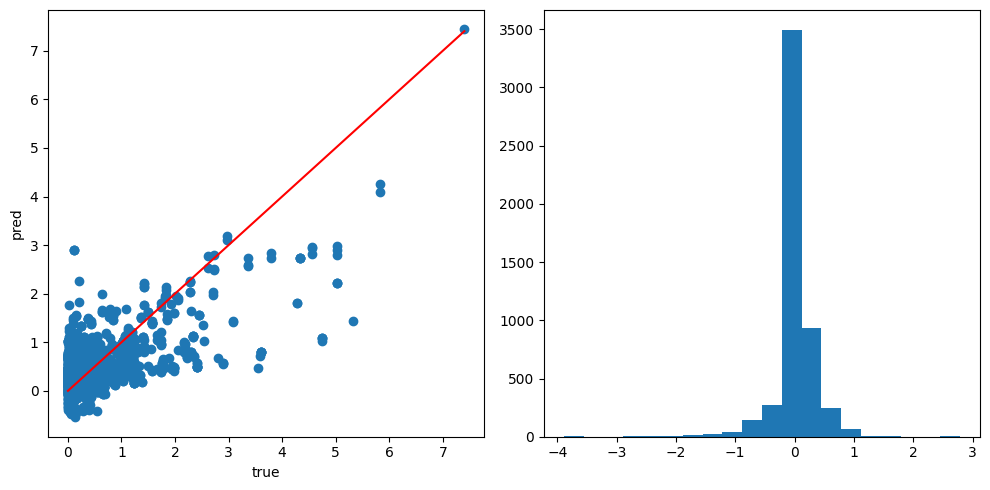

In [ ]:
y_pred = model(X_val).detach().numpy()
y_true = y_val.detach().numpy()
y_pred = y_pred[np.argwhere(y_pred<150)].reshape(-1,)
y_true = y_true[np.argwhere(y_true<150)].reshape(-1,)

for i in range(5):
    print(f"pred: {y_pred[i]}, true: {y_true[i]}")

fig, ax = plt.subplots(1,2, layout='tight', figsize=(10,5))
ax[0].scatter(y_true, y_pred)
ax[0].plot(np.linspace(np.min(y_true), np.max(y_true),100), np.linspace(np.min(y_true), np.max(y_true),100), color='red')
ax[1].hist(y_pred-y_true, bins=20);

ax[0].set_xlabel('true')
ax[0].set_ylabel('pred')

# Unsupervised

In [87]:
mldf.head(2)

,cluster_label,miles_walked_in_cluster,temperature_c,rel_humidity,cloud_cover,is_day,precipitation,supermarket,hair_care,grocery_or_supermarket,shopping_mall,bus_station,parking,bakery,liquor_store,storage,spa,park,museum,place_of_worship,subway_station,clothing_store,bar,tourist_attraction,cafe,health,airport,restaurant,lodging,transit_station,store,food
0,2,0.176681,17.927586,66.904978,96.155172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.369790,16.066854,64.661242,98.958333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
svd = TruncatedSVD(n_components=4)
tdf = svd.fit_transform(mldf.drop(columns=['cluster_label']))
tdf

array([[ 1.15845372e+02,  2.49560815e+01,  3.89503735e-01,
        -3.06002781e-01],
       [ 1.15775711e+02,  2.87525289e+01, -9.98976061e-01,
        -3.34123047e-01],
       [ 5.50592865e+01, -4.98731054e+01, -3.29026866e+00,
        -3.99925984e-02],
       ...,
       [ 1.37292954e+02,  1.06529711e+01,  9.94547458e-01,
        -2.24134899e-01],
       [ 1.37447653e+02,  7.16961000e+00,  3.95825005e-01,
        -2.93264158e-01],
       [ 1.37163015e+02,  1.07869439e+01,  1.49847291e+00,
        -2.65471102e-01]], shape=(560, 4))

In [108]:
svd.explained_variance_ratio_
mldf.columns[np.argmax(svd.components_[0])]

'temperature_c'

In [103]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='pca', perplexity=200, random_state=10).fit_transform(tdf)
X_embedded

array([[ 2.9665549 ,  1.968823  ],
       [ 3.0749373 ,  2.2276714 ],
       [-5.3611765 , -2.2738976 ],
       ...,
       [ 4.164581  , -0.43515706],
       [ 4.177153  , -0.8303313 ],
       [ 4.102038  , -0.4021292 ]], shape=(560, 2), dtype=float32)

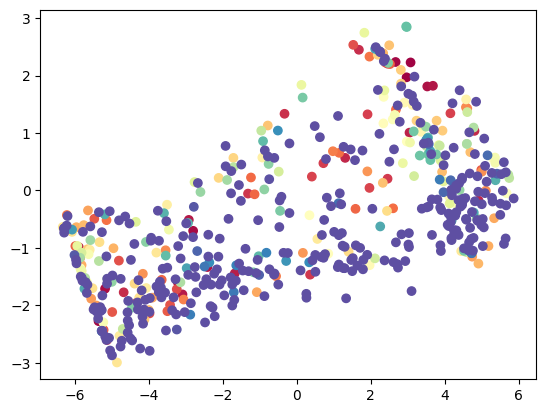

In [104]:
keys = mldf['cluster_label']
colors = plt.get_cmap(name='Spectral')
colors = [colors(i) for i in range(len(keys))]
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color=colors)

# Bottom